In [1]:
import os, json, sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from m_lime.explainers.explainer_linear import ExplainerLinear
from m_lime.explainers.visualizations.visualization import ImagePlot
from m_lime.generators.vae_gen import VAEGen

# Loadind data and Model

In [2]:
import torch
import torch.utils.data
from torchvision import datasets, transforms

from playground.models import mnist_CNN

In [3]:
epochs = 10
cuda = torch.cuda.is_available()
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tiagobotari/tiagobotari/data/MNIST1/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tiagobotari/tiagobotari/data/', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
path='model_mnist_cnn.pth'
model = mnist_CNN.model_load(device, path=path)
def model_predict(x_):
    if isinstance(x_, torch.Tensor):
        x_tf = x_
    else:
        x_tf = torch.from_numpy(x_)
    with torch.no_grad():
        x_tf = x_tf.reshape(-1, 1, 28, 28)
        y = model(x_tf.to(device=device))
        y = y.data.exp().to(device_cpu).numpy()
        return y

In [5]:
# x_explain = np.loadtxt('five_example0.949.np').astype(np.float32)
# fig, axis = plt.subplots(5,5, figsize=(15, 5))
# axis = axis.reshape(-1)
# for ax in axis:
#      index = np.random.choice(range(125))
# #      x_explain = x_examples[index][0]
#      with torch.no_grad():
#          y = model_predict(x_explain.view(-1, 1, 28, 28))
#          y = f'prediction: {np.argmax(y):}' #index: {index:} -
#      cp = plot_instances(ax, x_explain, y)

## DensityVAE

In [6]:
density = VAEGen(input_dim=784)
# density.fit(train_loader, epochs=40)
# density.save_manifold('./model_vae_manifold.pth')
density = density.load_manifold('./model_vae_manifold.pth')

In [7]:
def get_explanation(x_explain, model_predict, class_to_explain, local_class, r):
    print("Explanation for: ", class_to_explain)
    print("Probability:", model_predict(x_explain)[0][class_to_explain])
    explain_linear = ExplainerLinear(
        model_predict=model_predict, density=density, local_model=local_class, verbose=False)
    explanation, contra = explain_linear.explain_instance(
        x_explain=x_explain,
        r=r,
        n_samples=500,
        class_index=class_to_explain,
        tol=0.005,
        weight_kernel=None,
        local_mini_batch_max=20,
        scale_data=False
    )
    return explanation, contra

def plot_(explain_dict, contra):
    y = 'Prediction: f{np.argmax(y_explain):}'
    importances_ = explain_dict['importances']
    fig, axis = plt.subplots(figsize=(5, 5))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
    ax = ImagePlot.plot_instances(axis, x_explain[0], y)
    a = ImagePlot.plot_importance(importances_, standardization=True)
    fig, axis = plt.subplots(1, 2)
    axis = axis.reshape(-1)
    plot = ImagePlot.plot_instances(
        axis[1], contra.samples_con[0].reshape(28,28), f'Contrary\n Prob.: {contra.y_con[0]:5.3f}')
    plot = ImagePlot.plot_instances(
        axis[0], contra.samples_fav[0].reshape(28,28), f'Favorable\n Prob.: {contra.y_fav[0]:5.3f}')

def explain(x_explain, model_predict, class_to_explain, local_class, r):
    explanation, contra = get_explanation(
        x_explain, model_predict, class_to_explain, local_class, r)
    explain_dict = explanation.explain()
    plot_(explain_dict, contra)
    return explanation

In [8]:
local_class = 'SGD'
r = 1.0
explain_linear = None
torch.cuda.empty_cache()

### Explain a instance

In [9]:
x_explain = np.loadtxt('five_example0.949.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('Predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('Top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain):}'

Predicted: 5 0.44421804
Top 3 predicted Class [5 6 8]


## Explantion for the top 5 Classes

Explanation for:  5
Probability: 0.44421804


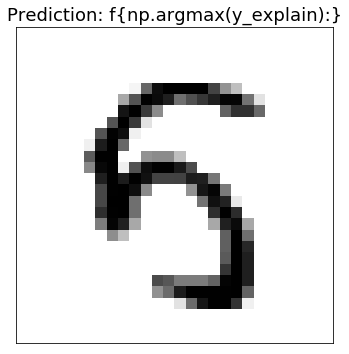

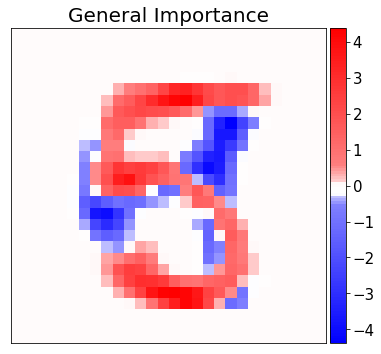

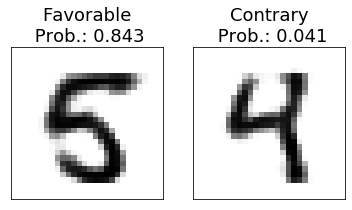

In [10]:
explanation = explain(
    x_explain, model_predict, top_three[0], local_class=local_class, r=r)

Explanation for:  6
Probability: 0.16739056


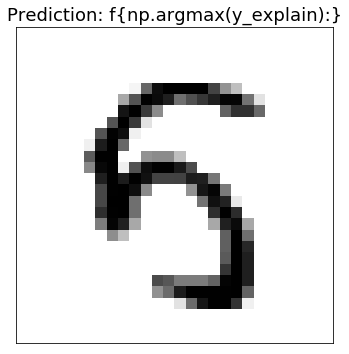

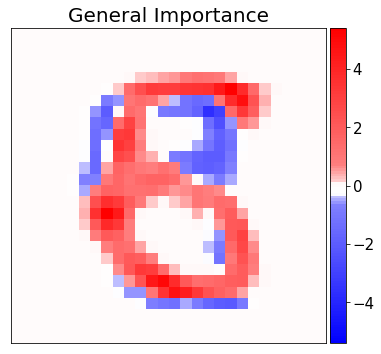

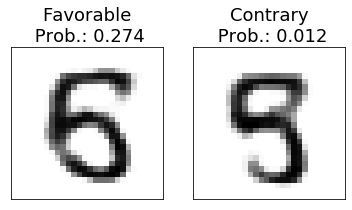

In [11]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  8
Probability: 0.15582435


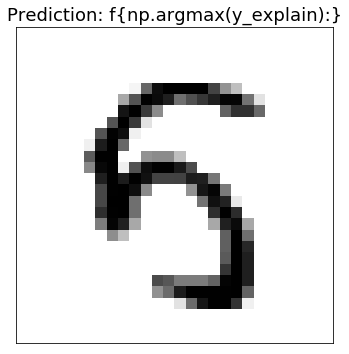

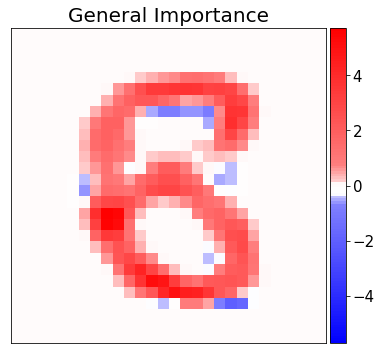

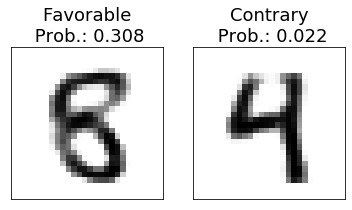

In [12]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

Explanation for:  9
Probability: 0.08754067


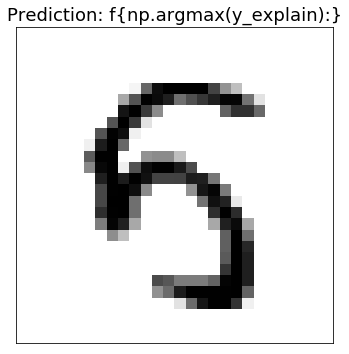

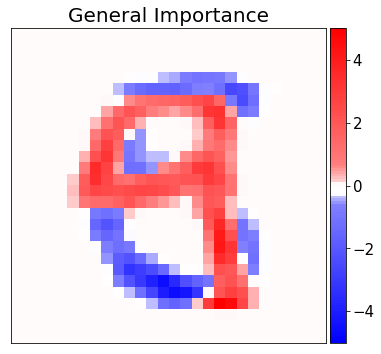

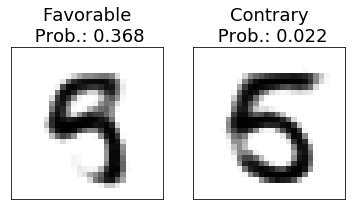

In [13]:
explanation = explain(x_explain, model_predict, top_three[3], local_class, r)

# Explain number 5

In [14]:
x_explain = np.loadtxt('five_example0.879.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain)}'

predicted: 5 0.52969086
top 3 predicted Class [5 3 9]


Explanation for:  5
Probability: 0.52969086


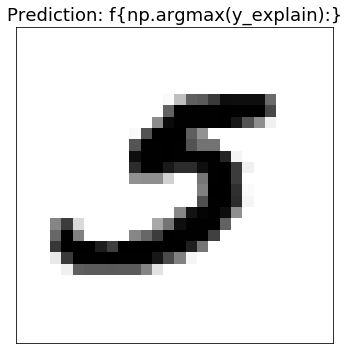

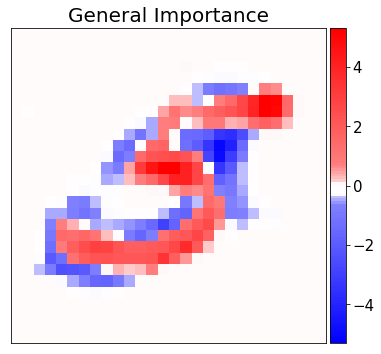

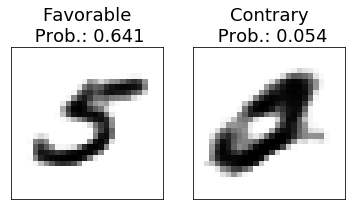

In [15]:
explanation = explain(x_explain, model_predict, top_three[0], local_class, r)

Explanation for:  3
Probability: 0.21647812


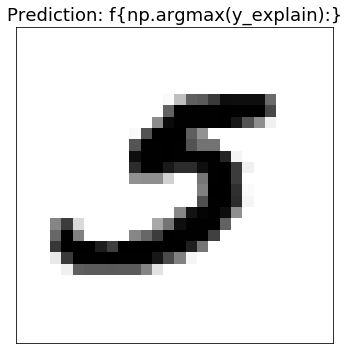

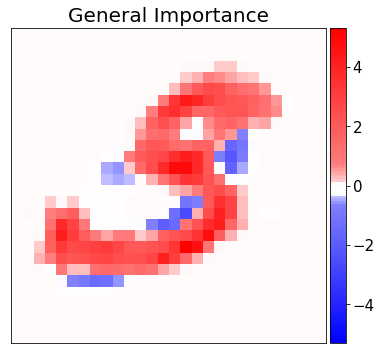

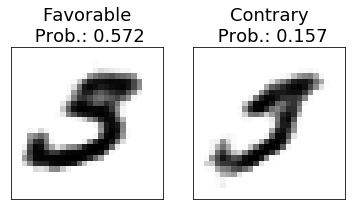

In [16]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  9
Probability: 0.08599733


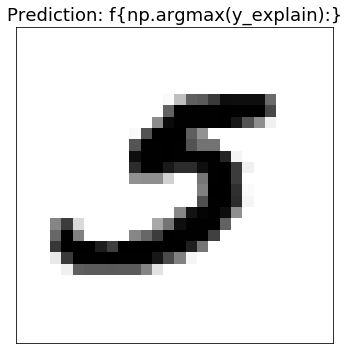

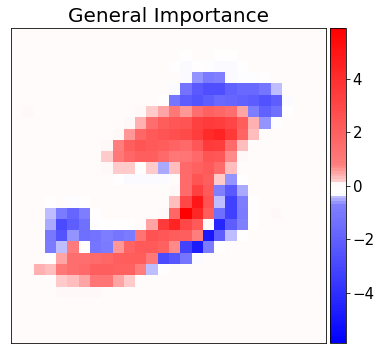

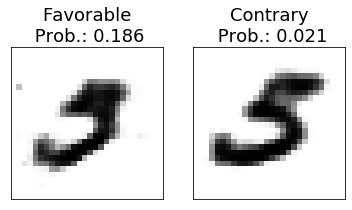

In [17]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

# Explain number 3

In [18]:
x_explain = np.loadtxt('three_example0.951.np').astype(np.float32).reshape(1, 28, 28)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)
print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
y = f'Prediction: {np.argmax(y_explain):}'

predicted: 3 0.31112874
top 3 predicted Class [3 9 5]


Explanation for:  3
Probability: 0.31112874


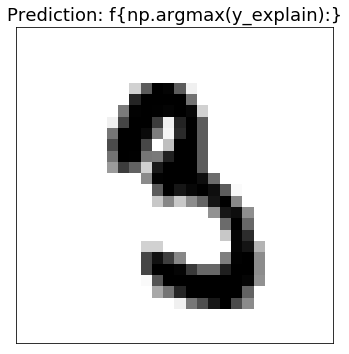

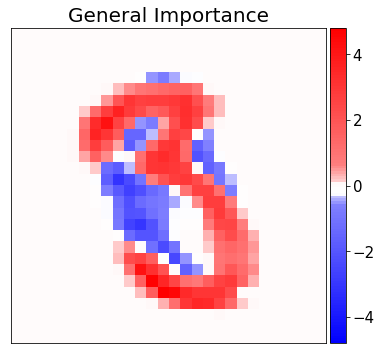

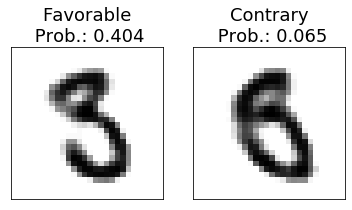

In [19]:
explanation = explain(x_explain, model_predict, top_three[0], local_class, r)

Explanation for:  9
Probability: 0.18863097


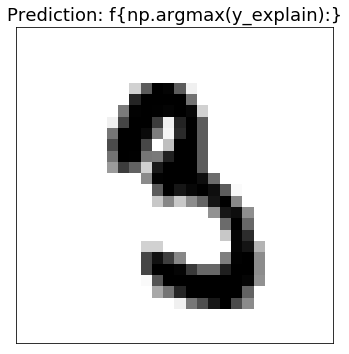

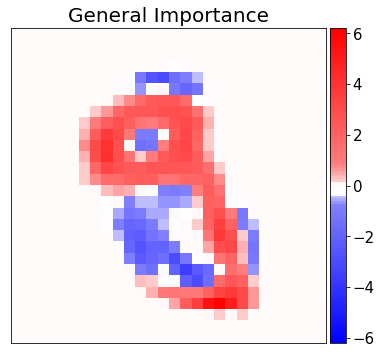

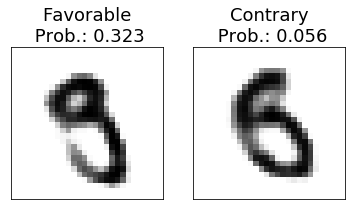

In [20]:
explanation = explain(x_explain, model_predict, top_three[1], local_class, r)

Explanation for:  5
Probability: 0.13742018


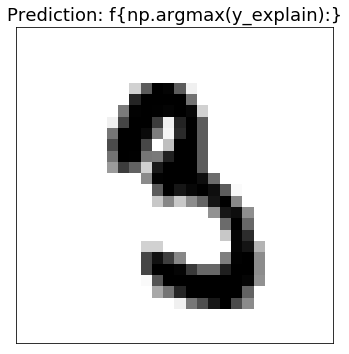

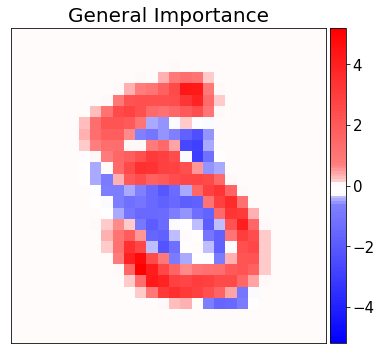

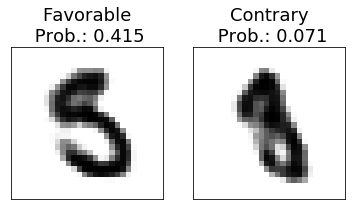

In [21]:
explanation = explain(x_explain, model_predict, top_three[2], local_class, r)

Explanation for:  8
Probability: 0.09787022


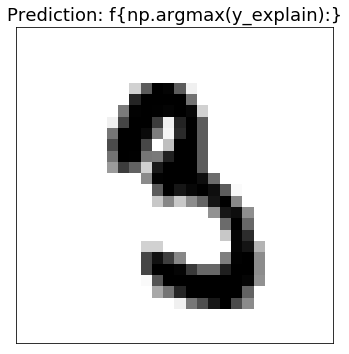

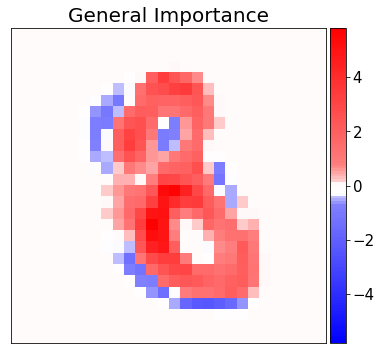

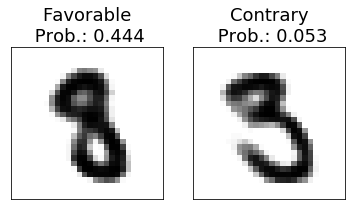

In [22]:
explanation = explain(x_explain, model_predict, top_three[3], local_class, r)